In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
#export
from exp.nb_03 import *
from fastprogress import master_bar, progress_bar

In [5]:
x_train,y_train,x_valid,y_valid = get_data(mnist_path)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [6]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [7]:
#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [8]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in progress_bar(dl, parent=): self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            mb=master_bar(range(epochs))
            for epoch in mb:
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None
    
    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res            

In [9]:
learn = create_learner(get_model, loss_func, data)

In [10]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: raise CancelTrainException()
            
    def after_fit(self):
        print(f'completed {self.run.n_epochs}')

In [11]:
run = Runner(cb_funcs=TestCallback)

In [52]:
run.fit(1, learn)

0
1
2
3
4
5
6
7
8
9
10
completed 0.11224489795918366


In [12]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [13]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [14]:
learn = create_learner(get_model, loss_func, data)

In [15]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [16]:
run.fit(2, learn)

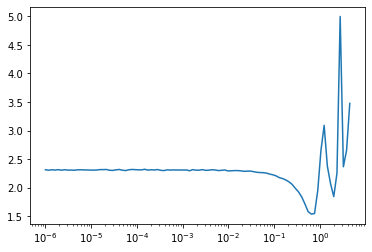

In [17]:
run.recorder.plot(skip_last=5)

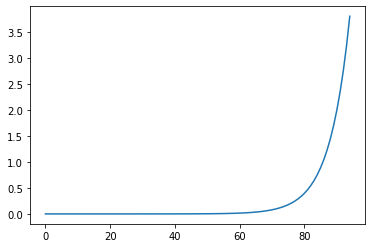

In [59]:
run.recorder.plot_lr()

In [60]:
#export
torch.set_num_threads(2)

In [61]:
from inspect import getsource
print(getsource(get_data))

def get_data(path):
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _)= pickle.load(f, encoding='latin_1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))



In [62]:
print(getsource(normalize))

def normalize(x, m, s): return (x-m)/s



In [18]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [19]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [20]:
x_train.mean(),x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [21]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [22]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [23]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [24]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 3, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [25]:
model = get_cnn_model(data)

In [26]:
cbfs=[]

In [29]:
cbfs.append(partial(AvgStatsCallback,accuracy))
cbfs.append(partial(ParamScheduler, 'lr', sched))

In [30]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [31]:
%time run.fit(1, learn)

train: [2.261284375, tensor(0.1788)]
valid: [2.202282421875, tensor(0.3207)]
train: [2.261284375, tensor(0.1788)]
valid: [2.202282421875, tensor(0.3207)]
Wall time: 29 s


In [90]:
device = torch.device('cuda',0)

In [91]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [92]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [207]:
cbfs.append(CudaCallback)

In [94]:
model = get_cnn_model(data)

In [95]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [96]:
%time run.fit(3, learn)

train: [1.690098125, tensor(0.4331, device='cuda:0')]
valid: [0.483099267578125, tensor(0.8580, device='cuda:0')]
train: [0.340702109375, tensor(0.8990, device='cuda:0')]
valid: [0.18256282958984374, tensor(0.9466, device='cuda:0')]
train: [0.18665140625, tensor(0.9439, device='cuda:0')]
valid: [0.1310271728515625, tensor(0.9613, device='cuda:0')]
Wall time: 13.5 s


In [81]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [82]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [208]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

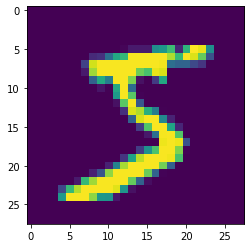

In [84]:
plt.imshow(mnist_view(x_train[0]).squeeze())

In [144]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [145]:
nfs=[8, 16, 32, 32]

In [151]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [152]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [209]:
cbfs.append(Recorder)

In [154]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [155]:
run.fit(3, learn)

train: [2.075436875, tensor(0.2643, device='cuda:0')]
valid: [1.1801779296875, tensor(0.5955, device='cuda:0')]
train: [0.5556317578125, tensor(0.8246, device='cuda:0')]
valid: [0.2244111083984375, tensor(0.9329, device='cuda:0')]
train: [0.20020455078125, tensor(0.9399, device='cuda:0')]
valid: [0.1587503662109375, tensor(0.9512, device='cuda:0')]


In [156]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [210]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [211]:
run.fit(2, learn)

train: [2.212299375, tensor(0.1906, device='cuda:0')]
valid: [1.7798375, tensor(0.4251, device='cuda:0')]
train: [0.60864515625, tensor(0.8156, device='cuda:0')]
valid: [0.2333783447265625, tensor(0.9290, device='cuda:0')]


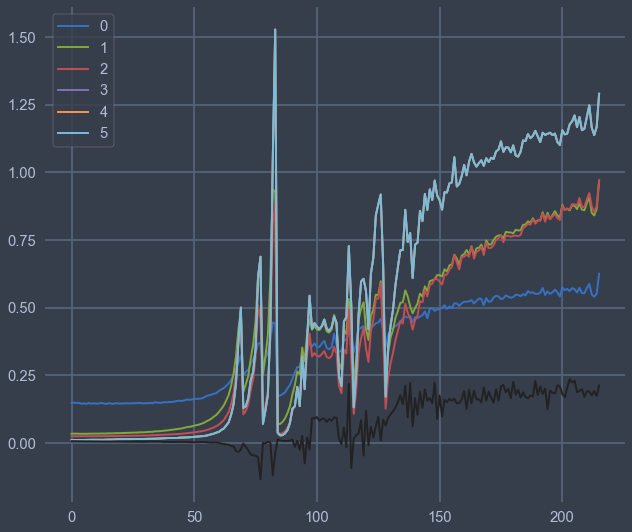

In [212]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

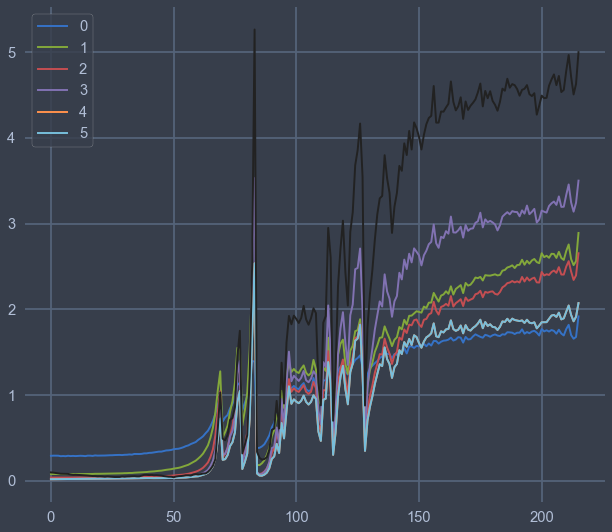

In [213]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6))

In [186]:
cbfs.append(Recorder)

In [242]:
def plot_themes(theme: str):
    from jupyterthemes import jtplot
    jtplot.style(theme=theme)
    jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='-.')

In [243]:
plot_themes('monokai')

In [214]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [215]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [216]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [217]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [218]:
run.fit(3, learn)

train: [2.23042578125, tensor(0.1915, device='cuda:0')]
valid: [1.2707298828125, tensor(0.5374, device='cuda:0')]
train: [0.755763046875, tensor(0.7414, device='cuda:0')]
valid: [0.2865415283203125, tensor(0.9059, device='cuda:0')]
train: [0.238746484375, tensor(0.9237, device='cuda:0')]
valid: [0.1715579345703125, tensor(0.9485, device='cuda:0')]


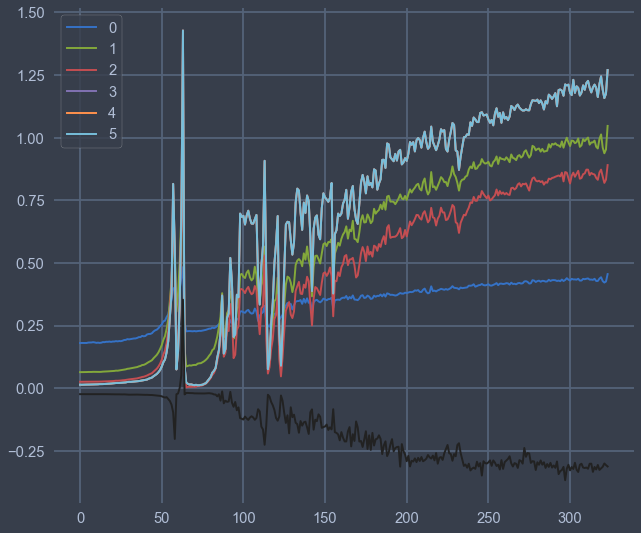

In [219]:
for l in act_means: plt.plot(l)
plt.legend(range(6))

In [28]:
sched = combine_scheds([0.25, 0.75], [sched_cos(0.35, 0.6), sched_cos(0.6, 0.2)])

In [221]:
run.fit(3, learn)

train: [0.3918642578125, tensor(0.8800, device='cuda:0')]
valid: [0.18797056884765626, tensor(0.9402, device='cuda:0')]
train: [0.1641380078125, tensor(0.9488, device='cuda:0')]
valid: [0.1346714111328125, tensor(0.9596, device='cuda:0')]
train: [0.106094951171875, tensor(0.9669, device='cuda:0')]
valid: [0.09724142456054688, tensor(0.9728, device='cuda:0')]


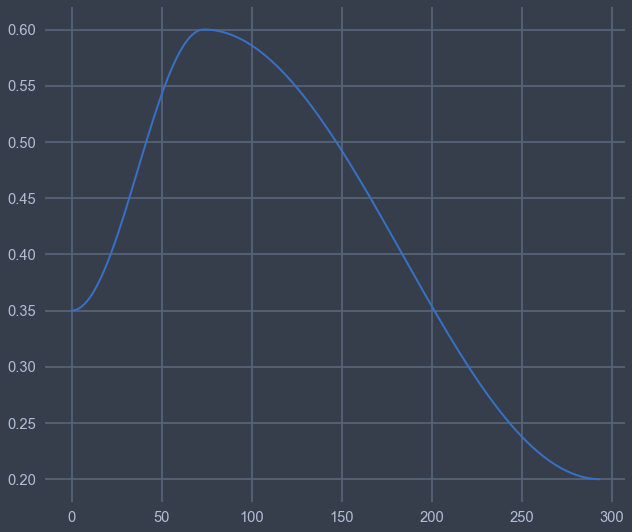

In [222]:
run.recorder.plot_lr()

In [223]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [224]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [225]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [226]:
run.fit(1, learn)

train: [2.2715203125, tensor(0.1673, device='cuda:0')]
valid: [2.0238857421875, tensor(0.2791, device='cuda:0')]


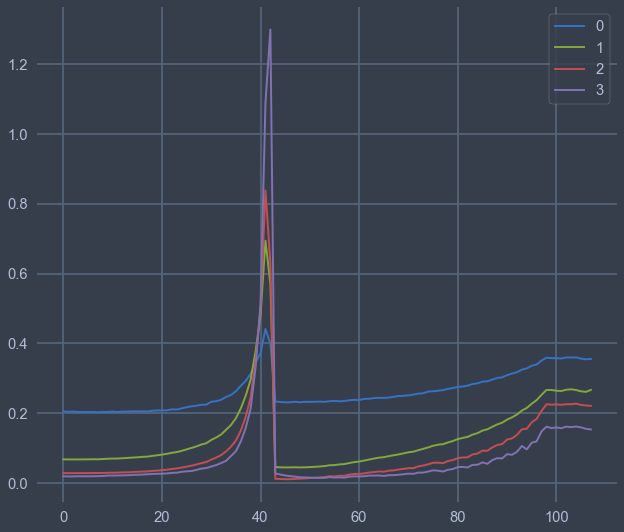

In [227]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

In [228]:
#export
class L():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [229]:
L(range(20))

L (20 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [231]:
#export
from torch.nn import init

class Hooks(L):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [232]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [233]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x000001C1337F4548>, <__main__.Hook object at 0x000001C16463D7C8>, <__main__.Hook object at 0x000001C16463D6C8>, <__main__.Hook object at 0x000001C16463D988>, <__main__.Hook object at 0x000001C160D6CB48>, <__main__.Hook object at 0x000001C1647EC808>, <__main__.Hook object at 0x000001C1624EEB88>]

In [234]:
hooks.remove()

In [235]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [236]:
x.shape

torch.Size([512, 1, 28, 28])

In [239]:
temp=model[0](x)
temp.mean(), temp.std()

(tensor(0.1451, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3271, device='cuda:0', grad_fn=<StdBackward0>))

In [240]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

train: [0.188866328125, tensor(0.9428, device='cuda:0')]
valid: [0.12154134521484375, tensor(0.9643, device='cuda:0')]
train: [0.107143955078125, tensor(0.9678, device='cuda:0')]
valid: [0.09632921142578126, tensor(0.9724, device='cuda:0')]


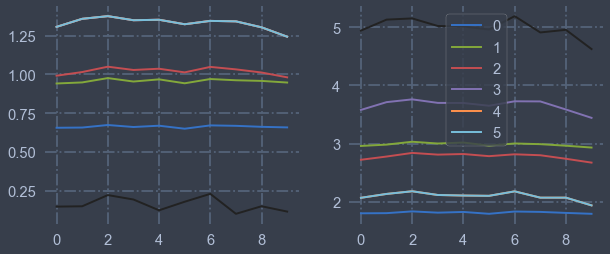

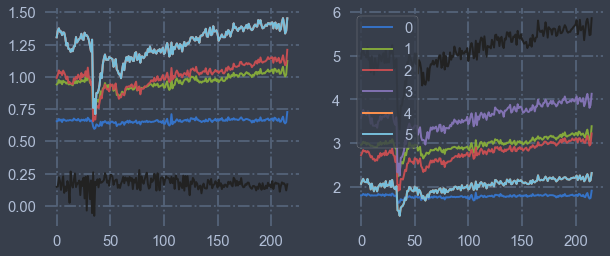

In [244]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [245]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [246]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [247]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [248]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [249]:
run.fit(8, learn)

train: [1.1523034375, tensor(0.6333, device='cuda:0')]
valid: [0.274904736328125, tensor(0.9121, device='cuda:0')]
train: [0.22595509765625, tensor(0.9300, device='cuda:0')]
valid: [0.140859765625, tensor(0.9591, device='cuda:0')]
train: [0.14237240234375, tensor(0.9566, device='cuda:0')]
valid: [0.101008935546875, tensor(0.9700, device='cuda:0')]
train: [0.089543095703125, tensor(0.9726, device='cuda:0')]
valid: [0.08033550415039062, tensor(0.9770, device='cuda:0')]
train: [0.070683583984375, tensor(0.9781, device='cuda:0')]
valid: [0.07029547729492187, tensor(0.9784, device='cuda:0')]
train: [0.0568545703125, tensor(0.9821, device='cuda:0')]
valid: [0.0653819091796875, tensor(0.9809, device='cuda:0')]
train: [0.049141787109375, tensor(0.9853, device='cuda:0')]
valid: [0.06826834716796874, tensor(0.9807, device='cuda:0')]
train: [0.043835625, tensor(0.9871, device='cuda:0')]
valid: [0.06771209716796875, tensor(0.9814, device='cuda:0')]


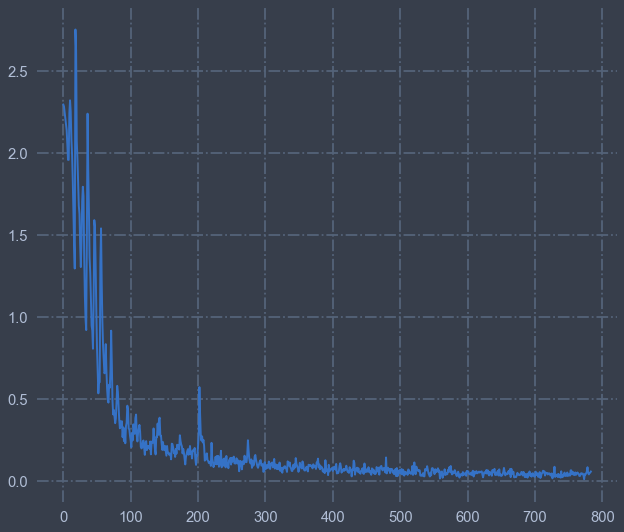

In [250]:
run.recorder.plot_loss()

In [252]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs)

In [253]:
run.fit(8, learn)

train: [1.3969490625, tensor(0.5426, device='cuda:0')]
valid: [0.2952171630859375, tensor(0.9096, device='cuda:0')]
train: [0.24867287109375, tensor(0.9242, device='cuda:0')]
valid: [0.16503187255859375, tensor(0.9477, device='cuda:0')]
train: [0.138197646484375, tensor(0.9578, device='cuda:0')]
valid: [0.1183356689453125, tensor(0.9673, device='cuda:0')]
train: [0.100436513671875, tensor(0.9692, device='cuda:0')]
valid: [0.08928955078125, tensor(0.9749, device='cuda:0')]
train: [0.0729484228515625, tensor(0.9768, device='cuda:0')]
valid: [0.0855510986328125, tensor(0.9751, device='cuda:0')]
train: [0.060745546875, tensor(0.9809, device='cuda:0')]
valid: [0.0742557373046875, tensor(0.9795, device='cuda:0')]
train: [0.0516173291015625, tensor(0.9839, device='cuda:0')]
valid: [0.07019502563476562, tensor(0.9803, device='cuda:0')]
train: [0.0460364990234375, tensor(0.9857, device='cuda:0')]
valid: [0.07129669799804687, tensor(0.9807, device='cuda:0')]


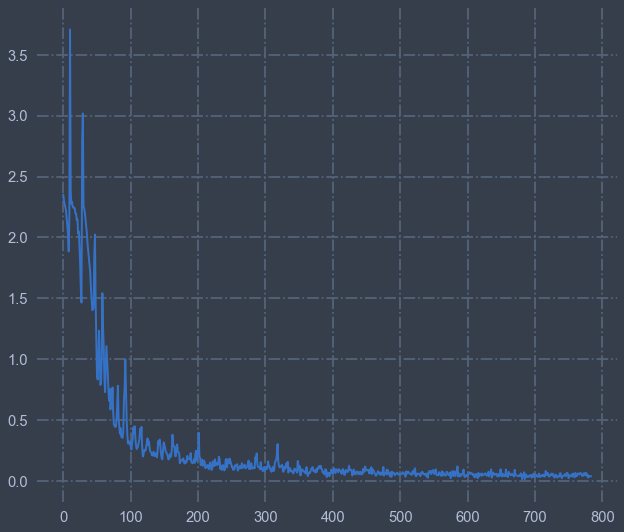

In [254]:
run.recorder.plot_loss()

In [255]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()